# Sentiment analysis using recurrent neural networks
One of the things I find fascinating about applying machine learning algorithms to natural language processing tasks is how you get get a bunch of words that actually mean something, convert them to [a bunch of numbers](), and the computer is able to understand what those numbers represent in the vocabulary of the NLP task at hand.

In this notebook, I will use a [recurrent neural network]() to perform [sentiment analysis]() on a given dataset.

### Recurrent neural networks
Recurrent neural networks (RNNs) are suitable for deep learning tasks that take in a sequence of data as input. The individual data in the sequence usually tell a complete story as a whole but may not offer meaningful information standalone. Also, the number of elements in the sequence of data do not need to be fixed for a given ML task as RNNs are very flexible in dealing with variable sizes of input.

Good examples of tasks suitable for RNNs are:
1. Predicting the price of a stock based on its prices in the last 30 days.
2. Predicting the next word in a sentence given preceeding words.
3. Speech to text translation

### The task at hand
Human beings routinely express their pleasure (or displeasure) about particular experiences. It could be whether a movie you watched was good (or not), if your commute to work was pleasant or stressful, if you enjoyed your lunch or if you had a tedious experience getting an insurance company to honour your claim. The question to answer here is "based on what this person said, do they feel good or feel bad about their experience?"

The goal of sentiment analysis in NLP is to enable a machine answer this question. For example, you want a machine to be able to look at the following sentence

> I really enjoyed playing FIFA today

and indicate that the user "felt good" (or "felt bad" or did not feel anything at all) about this.

<img src="https://vitalflux.com/wp-content/uploads/2021/10/sentiment-analysis-machine-learning-techniques.png" alt="Sentiment analysis" style="width: 500px;"/>


### Dataset
The [Twitter US airline sentiment](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment?resource=download) dataset will be used for this task.

In [117]:
import csv
import html

csv_file = open("twitter-us-airline-sentiment.csv")
csvreader = csv.reader(csv_file)

headers = []
headers = next(csvreader)

sentiment_index = headers.index("airline_sentiment")
tweet_index = headers.index("text")

inputs = []
categories = []
data = []
for row in csvreader:
    sentiment = row[sentiment_index]
    text = html.unescape(row[tweet_index])
    inputs.append(text)
    categories.append(sentiment)

print("{} inputs in the dataset, with categories={}".format(len(inputs), set(categories)))
inputs[0:5]

14640 inputs in the dataset, with categories={'positive', 'neutral', 'negative'}


['@VirginAmerica What @dhepburn said.',
 "@VirginAmerica plus you've added commercials to the experience... tacky.",
 "@VirginAmerica I didn't today... Must mean I need to take another trip!",
 '@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces & they have little recourse',
 "@VirginAmerica and it's a really big bad thing about it"]

Split data into training / test data

In [118]:
from torch.utils.data import random_split

total_dataset_count = len(inputs)
train_indices, test_indices = random_split(range(total_dataset_count), [0.7, 0.3])

train_X, train_Y = [inputs[idx] for idx in train_indices],  [categories[idx] for idx in train_indices]
test_X, test_Y = [inputs[idx] for idx in test_indices],  [categories[idx] for idx in test_indices]

Print out some data samples in tabular form

In [119]:
from tabulate import tabulate

def print_in_tabular_form(headers, body): 
    entry_count = len(body[0])
    col_count = len(headers)
    tabular_data = [[column[index] for column in body] for index in range(entry_count)]
    print(tabulate(tabular_data, headers=headers, tablefmt="grid", maxcolwidths=[100 / col_count for idx in range(col_count)]))

print_in_tabular_form(["Train X", "Train Y"], [train_X[0:3], train_Y[0:3]])
print_in_tabular_form(["Test X", "Test Y"], [test_X[0:3], test_Y[0:3]])

+----------------------------------------------------+-----------+
| Train X                                            | Train Y   |
+====================================================+===========+
| @united yes. On a nonstop to Memphis tomorrow      | neutral   |
| morning. With the snow coming in I got my fingers  |           |
| crossed it will go.                                |           |
+----------------------------------------------------+-----------+
| @SouthwestAir could u put one here in Baltimore?   | neutral   |
| http://t.co/vLCI2KV1IP                             |           |
+----------------------------------------------------+-----------+
| @united thanks for the reply.  If you can get me a | positive  |
| better seat on my next leg to Munich. That would   |           |
| be nice.                                           |           |
+----------------------------------------------------+-----------+
+----------------------------------------------------+--------

Pytorch provides the `Dataset` and `Dataloader` classes that we can customize to help us load data in batches

In [120]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

def get_training_and_test_dataloaders(X, y, training_data_porpotion=0.7, batch_size=10):
    total_dataset_count = len(X)
    train_indices, test_indices = random_split(range(total_dataset_count), [training_data_porpotion, 1 - training_data_porpotion])

    train_X, train_Y = [X[idx] for idx in train_indices],  [y[idx] for idx in train_indices]
    test_X, test_Y = [X[idx] for idx in test_indices],  [y[idx] for idx in test_indices]

    training_dataset = CustomDataset(train_X, train_Y)
    test_dataset = CustomDataset(test_X, test_Y)

    training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return training_dataloader, test_dataloader

training_loader, test_loader = get_training_and_test_dataloaders(inputs, categories, batch_size=5)

A batch of data looks like this

In [121]:
next(iter(training_loader))

[('@JetBlue People kept saying it was due to weather but there were flights going directly to boston even after our flight.',
  "@JetBlue Thank you for the reply. Would've appreciated communication before checking in about the delay. JetBlue used to be my go-to",
  '@JetBlue Found someone to ask. No answers. Landed almost 40 minutes ago.',
  '@united #customerservice at @Dulles_Airport could not be worse. I get the bad weather, but this is awful.',
  '@AmericanAir ask the 10 people you left behind at Miami airport because you guys could not wait 5 minutes and ... http://t.co/XPM98Igqjn'),
 ('negative', 'negative', 'negative', 'negative', 'negative')]

### Data pre-processing in NLP

Before we get to the part where we convert a piece of text into "a bunch of numbers", we need to make sure our text data is transformed to contain only useful information/signals that are relevant for the task at hand. 

#### Data cleaning

All of the transformation / pre-processing steps applied to raw text data to make it suitable NLP tasks is generally known as **data cleaning**.

The combination of data cleaning techniques to apply usually depend on the task at hand. One thing ML engineers like to do is experiment to find what set of steps give the best performance for a given NLP model. 

#### Transforming our input data

From inspecting the a subset of the input data, I want to perform the following data transformation steps
1. Transform all words to lower cases
2. Remove some parts of the input text
    1. Handles - (words that begin with "@")
    2. Links
3. Remove hash symbols in front of words
4. Replace known word breaks with spaces
5. Removing stop words - I am using the `spacy` NLP library to remove common occuring stop words.


In [122]:
from spacy.lang.en.stop_words import STOP_WORDS


def replace_known_word_breaks(text):
    return text.replace("...", ", ").replace("\n", " ")

def transform_raw_data(text):
    text = text.lower()

    text = replace_known_word_breaks(text)

    processed = []
    for word in text.split():
        if word.startswith('@') or word.startswith('http'):
            continue

        if word in STOP_WORDS:
            continue

        if word.startswith('#'):
            word = word[1:]

        processed.append(word)

    return " ".join(processed)


Let's test our transformation

In [123]:
batch_X, batch_y = next(iter(training_loader))
transformed_data = [transform_raw_data(row) for row in batch_X]
print_in_tabular_form(["Original", "Transformed"], [batch_X, transformed_data])

+----------------------------------------------------+----------------------------------------------------+
| Original                                           | Transformed                                        |
+====================================================+====================================================+
| @AmericanAir Telling frustrated customers "we are  | telling frustrated customers "we super busy, late  |
| super busy, please call back Late Flightr kthxbai" | flightr kthxbai" hanging best practice.            |
| and then hanging up is not the best practice.      |                                                    |
+----------------------------------------------------+----------------------------------------------------+
| @united strikes again! Why board anyone if there's | strikes again! board there's wrong plane? common   |
| something wrong with the plane? Common sense.      | sense.                                             |
+---------------------------

#### Vocabularies & Tokenization in NLP

Applying one or a combination of data cleaning steps above on our text data moves us closer to being able to feed our dataset into a neural network. Once we manage to clean all of the data we plan to use to train the NLP model (generally refered to as our [text corpus]()), the unique sets of words across the transformed data refers to our **vocabulary**.
Due to the high [dimensionality]() of text data, we **rarely feed all** the unique words encountered in our vocabulary to the neural network. We usually choose a poportion of them.

One popular way of building a vocabulary is to
1. Define how many words or what porpotion of unique words from your text corpus do you want in your vocabulary (let's say the number is represented by **n**).
2. Count the occurence of each word in the text corpus and sort from most occuring to least frequently occuring
3. Choose the **n** most frequently occuring tokens and use that as your vocabulary.

In the example below, I will show how to build a custom vocabulary

A piece of text -> A set of tokens (words that may mean something....they are usually present in the vocabulary)
1. build vocabulary
2. Convert piece to text to set of tokens (using the vocabulary)
- A unique set of words that best fit the NLP task you are trying to do.
- Vocabulary you need depends on the task at hand
- Vocabulary developed is usually gotten from the text corpus
- Vocabulary can be inherited
- OOV words
- Using a sentence example.

#### Tokenizing the transformations

In [124]:
from keras.preprocessing.text import Tokenizer

def build_vocabulary(token_size=2000):
    # Create a tokenizer and fit it on the texts
    transformed_data = [transform_raw_data(row) for row in inputs]
    tokenizer = Tokenizer(num_words=token_size, oov_token='OOV')
    tokenizer.fit_on_texts(transformed_data)
    return tokenizer

tokenizer = build_vocabulary()
print("{} unique words".format(len(tokenizer.word_counts)))

tokens = tokenizer.texts_to_sequences(transformed_data)
print_in_tabular_form(["Text", "Tokens"], [transformed_data[0:5], tokens[0:5]])

13719 unique words
+----------------------------------------------------+--------------------------------------------------+
| Text                                               | Tokens                                           |
+====================================================+==================================================+
| telling frustrated customers "we super busy, late  | [422, 350, 109, 681, 580, 494, 29, 129, 1, 1015, |
| flightr kthxbai" hanging best practice.            | 102, 1]                                          |
+----------------------------------------------------+--------------------------------------------------+
| strikes again! board there's wrong plane? common   | [1, 89, 204, 388, 334, 14, 1, 725]               |
| sense.                                             |                                                  |
+----------------------------------------------------+--------------------------------------------------+
| thanks hope destination  

Pad the tokens with '0' so the tokens can be represented as a matrix and convert to a tensor.

In [125]:
import torch
import tensorflow as tf

padded_tokens = torch.Tensor(tf.keras.utils.pad_sequences(tokens, padding='post')).to(torch.int)
padded_tokens.shape, padded_tokens[0]

(torch.Size([5, 12]),
 tensor([ 422,  350,  109,  681,  580,  494,   29,  129,    1, 1015,  102,    1],
        dtype=torch.int32))

Let's create a function to transform a batch of input data to a matrix of padded tokens

In [147]:
max_words_count_in_single_dataset = max([len(i.split()) for i in inputs])

def raw_data_to_tokens(batch_of_X, tokenizer, max_token_length = 20, print_transformations=True):
    transformed_data = [transform_raw_data(row) for row in batch_of_X]
    tokens = tokenizer.texts_to_sequences(transformed_data)
    padded_tokens = tf.keras.utils.pad_sequences(tokens, maxlen=max_token_length, padding='post')
    if print_transformations:
        print_in_tabular_form(["Raw Text", "Transformed", "Tokens", "Padded Tokens"], [batch_of_X, transformed_data, tokens, padded_tokens])
    return torch.Tensor(padded_tokens).to(int)

Create embedding matrix for all the tokens, including the padding token '0'

In [127]:
import torch.nn as nn

tokens_count = tokenizer.num_words
embedding_size = int(tokens_count ** 0.25)
# Adding 1 to token_size to cater for padding value '0'
embedding = nn.Embedding(tokens_count + 1, embedding_size)

Given a list of tokens, define a function that will return the embeddings of a batch of dataset

In [128]:
embeddings_batch = embedding(padded_tokens)
embeddings_batch.shape

torch.Size([5, 12, 6])

Define a RNN module

In [129]:
hidden_layers = 3
rnn = nn.RNN(embedding_size, hidden_layers, batch_first=True)

In [130]:
def compute(rnn, embeddings_batch):
    output, hidden_state = rnn(embeddings_batch)
    return output

rnn_output = compute(rnn, embeddings_batch)
rnn_output.shape

torch.Size([5, 12, 3])

Flatten the output on the last dimension so we can pass it to a fully connected NN in 2D shape

In [131]:
flattened = torch.flatten(rnn_output, start_dim=1)
flattened.shape

torch.Size([5, 36])

Define a fully connected NN that takes in the flattened output

In [132]:
input_layer_size = hidden_layers * padded_tokens.shape[1]
unique_categories = list(set(categories))
fully_connected = nn.Linear(input_layer_size,len(unique_categories))

In [133]:
nn_output = fully_connected(flattened)
nn_output.shape, nn_output

(torch.Size([5, 3]),
 tensor([[-0.4901, -0.0652,  0.4319],
         [ 0.0841,  0.3365, -0.0782],
         [-0.0311,  0.2040,  0.5606],
         [-0.5497, -0.2634,  0.1764],
         [ 0.3317,  0.1967, -0.0641]], grad_fn=<AddmmBackward0>))

Let's create the one-hot encoded matrix for the actual output so we can calculate the loss

In [134]:
index_for_categories = {}
category_count = len(unique_categories)
for index in range(category_count):
    cat = unique_categories[index]
    index_for_categories[cat] = index

print(index_for_categories)

def outputs_as_targets(output_batch):
    return torch.Tensor([index_for_categories[c] for c in output_batch]).to(int)

batch_target = outputs_as_targets(batch_y)
batch_y, batch_target 

{'positive': 0, 'neutral': 1, 'negative': 2}


(('negative', 'negative', 'positive', 'negative', 'negative'),
 tensor([2, 2, 0, 2, 2]))

Calculate the loss using cross-entropy loss function

In [135]:
criterion = nn.CrossEntropyLoss()
loss = criterion(nn_output, batch_target)
loss

tensor(1.0984, grad_fn=<NllLossBackward0>)

Apply back propagation

In [136]:
import torch.optim as optim

def create_optimizer(model, lr=0.1):
    return optim.SGD(model.parameters(), lr)

optimizers = [create_optimizer(m) for m in [embedding, rnn, fully_connected]]

for opt in optimizers:
    opt.zero_grad()

loss.backward()

for opt in optimizers:
    opt.step()

We just went through a training epoch!! 
Let's put it all together in a custom pytorch module

In [137]:
class SentimentAnalysisModule(torch.nn.Module):
    def __init__(self, max_sequences_length, tokens_count, rnn_hidden_layers, output_categories_count):
        super().__init__()
        embedding_size = int(tokens_count ** 0.25)
        
        self.embedding = nn.Embedding(tokens_count, embedding_size)
        self.rnn = nn.RNN(embedding_size, rnn_hidden_layers, batch_first=True)
        self.linear = nn.Linear(max_sequences_length * rnn_hidden_layers, output_categories_count)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input):
        embeddings = self.embedding(input)
        rnn_output, hidden_state = self.rnn(embeddings)
        flattened = torch.flatten(rnn_output, start_dim=1)
        output = self.linear(flattened)
        return self.sigmoid(output)

Prepare our dataloaders

In [158]:
all_transformed_data = [transform_raw_data(row) for row in inputs]
max_token_length = max([len(i.split()) for i in all_transformed_data])
tokenizer = build_vocabulary(500)
all_tokens = raw_data_to_tokens(all_transformed_data, tokenizer, max_token_length, print_transformations=False)

categories_as_targets = outputs_as_targets(categories)
training_loader, test_loader = get_training_and_test_dataloaders(all_tokens, categories_as_targets,
                                                                 training_data_porpotion=0.8,
                                                                 batch_size=50)

next(iter(training_loader))[0].shape

torch.Size([50, 24])

In [159]:
model = SentimentAnalysisModule(max_token_length, tokenizer.num_words + 1, 8, len(unique_categories))

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

And train a model

In [160]:
import time

num_epochs = 300

epoch_indices = []
avg_losses = []
avg_accuracies = []

confusion_mat = torch.zeros(len(unique_categories), len(unique_categories)).to(int)

for t in range(num_epochs + 1):
    losses = []
    tic = time.perf_counter()
    for batch_idx, (a_batch_of_X, a_batch_of_y) in enumerate(training_loader):
        output = model(a_batch_of_X)

        loss = criterion(output, a_batch_of_y)
        losses.append(loss.item())
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    accuracies = []
    for idx, (batch_of_X, batch_of_y) in enumerate(test_loader):
        output = model(batch_of_X)

        outputs_targets = torch.argmax(output, dim=1)

        diff = batch_of_y - outputs_targets
        correct = sum(diff == 0)
        accuracy =  correct / test_loader.batch_size
        accuracies.append(accuracy)

        if t != num_epochs:
            continue
        for i in range(outputs_targets.shape[0]):
            confusion_mat[batch_of_y[i].item(), outputs_targets[i].item()] += 1
    
    toc = time.perf_counter()

    epoch_indices.append(t)
    avg_loss = torch.mean(torch.Tensor(losses)).item()
    avg_acc = torch.mean(torch.Tensor(accuracies)).item()

    avg_losses.append(avg_loss)
    avg_accuracies.append(avg_acc)
    if t % 50 == 0:
        print("Epoch={}, avg loss={}, accuracy={}, took {:0.4f} seconds".format(t, avg_loss, avg_acc, toc - tic))

Epoch=0, avg loss=0.9118995070457458, accuracy=0.6216948628425598, took 1.5335 seconds
Epoch=50, avg loss=0.8010596632957458, accuracy=0.7179661393165588, took 0.8455 seconds
Epoch=100, avg loss=0.7857857942581177, accuracy=0.7301695346832275, took 0.9346 seconds
Epoch=150, avg loss=0.7626714110374451, accuracy=0.7233898639678955, took 0.6461 seconds
Epoch=200, avg loss=0.7512521147727966, accuracy=0.7264407277107239, took 0.8109 seconds
Epoch=250, avg loss=0.7479326128959656, accuracy=0.7338982820510864, took 1.0220 seconds
Epoch=300, avg loss=0.7400116324424744, accuracy=0.7352543473243713, took 0.7798 seconds


Show confusion matrix and plot the losses and accuracies 

In [161]:
print("Confusion matrix")
print(confusion_mat)

Confusion matrix
tensor([[ 233,   80,  169],
        [  43,  290,  278],
        [  46,  142, 1646]])


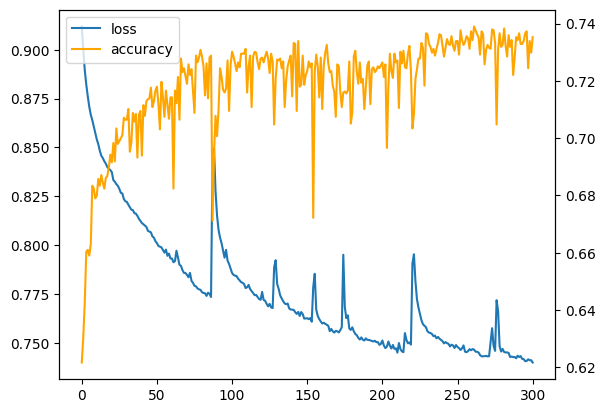

In [162]:
import matplotlib.pyplot as plt

ax1 = plt.subplot()
l1, = ax1.plot(avg_losses)
ax2 = ax1.twinx()
l2, = ax2.plot(avg_accuracies, color='orange')

plt.legend([l1, l2], ["loss", "accuracy"])

plt.show()